In [152]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.core.mutation import Mutation
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize

In [153]:
class CustomHybridMutation(Mutation):
    """Custom mutation for permutation (sequence) and integer (machine choices)."""
    def __init__(self, prob=0.1):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        n_individuals, n_var = X.shape
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        Y = X.copy()

        for i in range(n_individuals):
            # Permutation mutation
            if np.random.random() < self.prob:
                idx1, idx2 = np.random.choice(seq_length, size=2, replace=False)
                Y[i, :seq_length][[idx1, idx2]] = Y[i, :seq_length][[idx2, idx1]]
            # Machine choice mutation
            machine_choices = Y[i, seq_length:].reshape(seq_length, n_stages)
            for j in range(seq_length):
                for s in range(n_stages):
                    if np.random.random() < self.prob:
                        machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            Y[i, seq_length:] = machine_choices.flatten()

        return Y.astype(int)

class CustomHybridCrossover(Crossover):
    """Custom crossover for permutation and integer parts."""
    def __init__(self, prob=0.5):
        super().__init__(2, 2)
        self.prob = prob
        self.order_cx = OrderCrossover()
        self.uniform_cx = UniformCrossover(prob=prob)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape
        seq_length = problem.seq_length
        Y = np.zeros_like(X)

        for k in range(n_matings):
            a, b = X[:, k, :]
            perm_a, perm_b = self.order_cx._do(problem, np.array([[a[:seq_length]], [b[:seq_length]]]))[:, 0, :]
            machine_a, machine_b = self.uniform_cx._do(problem, np.array([[a[seq_length:]], [b[seq_length:]]]))[:, 0, :]
            Y[0, k, :seq_length] = perm_a
            Y[1, k, :seq_length] = perm_b
            Y[0, k, seq_length:] = machine_a
            Y[1, k, seq_length:] = machine_b

        return Y.astype(int)

class CustomHybridSampling(Sampling):
    """Custom sampling for permutation and integer parts."""
    def _do(self, problem, n_samples, **kwargs):
        seq_length = problem.seq_length
        n_stages = problem.n_stages
        X = np.zeros((n_samples, problem.n_var), dtype=int)

        for i in range(n_samples):
            X[i, :seq_length] = np.random.permutation(seq_length)
            machine_choices = np.zeros((seq_length, n_stages), dtype=int)
            for j in range(seq_length):
                for s in range(n_stages):
                    machine_choices[j, s] = np.random.randint(0, problem.machines_per_stage[s])
            X[i, seq_length:] = machine_choices.flatten()

        return X

In [ ]:
class HybridFlowshopSchedulingProblem(Problem):
    def __init__(self, user_sequence_idx, product_id_to_index, machines_per_stage, processing_times, changeover_times, order_quantities, unit_intervals, product_ids, product_required_stages, transfer_times=None, debug=False):
        self.seq_length = len(user_sequence_idx)
        self.user_sequence_idx = np.array(user_sequence_idx)
        self.product_id_to_index = product_id_to_index
        self.n_stages = len(machines_per_stage)
        self.machines_per_stage = machines_per_stage
        self.max_makespan = 0
        self.max_machines = max(machines_per_stage)
        self.debug = debug
        self.product_ids = product_ids
        self.product_index_to_required_stages = {self.product_id_to_index[rid]: stages for rid, stages in product_required_stages.items()}
        n_var = self.seq_length + (self.seq_length * self.n_stages)
        super().__init__(
            n_var=n_var,
            n_obj=1,
            n_constr=0,
            xl=[0] * n_var,
            xu=[self.seq_length - 1]*self.seq_length + [m - 1 for m in machines_per_stage for _ in range(self.seq_length)],
            type_var=int)
        self.processing_times = processing_times
        self.changeover_times = changeover_times
        self.order_quantities = order_quantities
        self.unit_intervals = unit_intervals
        self.transfer_times = transfer_times if transfer_times is not None else np.zeros((len(product_ids), self.n_stages))        

    def _evaluate(self, X, out, *args, **kwargs):
        makespans = np.array([self.calculate_makespan(x, store_best=False) for x in X])
        out["F"] = makespans

    def calculate_makespan(self, x, store_best=True):
        # Unpack Solution
        perm = x[:self.seq_length]
        machine_choices = x[self.seq_length:].reshape(self.seq_length, self.n_stages)
        job_product_indices = self.user_sequence_idx[perm]
        permuated_order_quantities = np.array(self.order_quantities)[perm]

        if self.debug and store_best:
            print(f"Calculating makespan for sequence: {job_product_indices}\nWith machine choices:\n{machine_choices}")
            print("====" * 20)

        # Initialize Tracking Arrays
        start_times = np.full((self.seq_length, self.n_stages), -1.0)
        end_times = np.full((self.seq_length, self.n_stages), -1.0)
        changeover_times_array = np.full((self.seq_length, self.n_stages), -1.0)
        machine_free_times = np.zeros((self.n_stages, self.max_machines))
        changeover_start_times = np.full((self.seq_length, self.n_stages), -1.0)
        changeover_end_times = np.full((self.seq_length, self.n_stages), -1.0)

        for job_idx in range(self.seq_length):
            job_product_index = job_product_indices[job_idx]
            required_stages = self.product_index_to_required_stages[job_product_index]
            order_quantity = permuated_order_quantities[job_idx]
            cumulative_tact_time = (order_quantity - 1) * self.unit_intervals[job_product_index]

            if not required_stages:
                continue

            for s_position, s in enumerate(required_stages):
                m = machine_choices[job_idx, s]

                # Find the last job scheduled on this machine at this stage
                last_job_on_machine = None
                for prev_job_idx in range(job_idx - 1, -1, -1):
                    prev_product_index = job_product_indices[prev_job_idx]
                    if s in self.product_index_to_required_stages[prev_product_index] and machine_choices[prev_job_idx, s] == m:
                        last_job_on_machine = prev_job_idx
                        break

                if last_job_on_machine is None:
                    changeover = 0
                    changeover_start = 0
                    changeover_end = 0
                    machine_ready_time = max(0, machine_free_times[s, m])
                else:
                    prev_product_index = job_product_indices[last_job_on_machine]
                    if prev_product_index != job_product_index:
                        changeover = self.changeover_times[s, m, prev_product_index, job_product_index]
                        changeover = changeover.item() if isinstance(changeover, np.ndarray) else changeover
                    else:
                        changeover = 0
                    changeover_start = end_times[last_job_on_machine, s]
                    changeover_end = changeover_start + changeover
                    machine_ready_time = changeover_end

                if s_position == 0:
                    # First required stage: can start when machine is ready
                    start_time = machine_ready_time
                else:
                    # For subsequent stages, check if no-wait condition is met
                    prev_s = required_stages[s_position - 1]
                    transfer_time = self.transfer_times[job_product_index, prev_s]
                    if self.debug and store_best:
                        print(f"  [DEBUG] Job {job_idx}, Product {self.product_ids[job_product_index]}: Wait/transport time after stage {prev_s} = {transfer_time}")                    
                    required_start = end_times[job_idx, prev_s] + transfer_time - cumulative_tact_time
                    start_time = max(required_start, machine_ready_time)

                    if start_time > required_start:
                        postpone_amount = start_time - required_start

                        if self.debug and store_best:
                            print(f"Postponing Product ID {self.product_ids[job_product_index]} at Stage {s} by {postpone_amount} time units to meet no-wait condition.")
                            prev_job_idx = next(
                                (prev_job_idx for prev_job_idx in range(job_idx - 1, -1, -1)
                                if s in self.product_index_to_required_stages[job_product_indices[prev_job_idx]] and machine_choices[prev_job_idx, s] == m),
                                None
                            )
                            if prev_job_idx is not None:
                                print(f"  Previous job on this machine: Product Index {job_product_indices[prev_job_idx]} (Product ID {self.product_ids[job_product_indices[prev_job_idx]]}), ends at {end_times[prev_job_idx, s]}")
                            else:
                                print("  No previous job on this machine at this stage.")
                            print(f"  end_times[last_job_on_machine, {s}]", end_times[last_job_on_machine, s] if last_job_on_machine is not None else None)
                            print(f"  machine_free_times[{s}, {m}]: {machine_free_times[s, m]}")
                            print("  changeover_start:", changeover_start)
                            print("  changeover:", changeover)
                            print("  changeover_end:", changeover_end)
                            print(f"  machine_ready_time: {start_time}")
                            print(f"  required_start: {required_start}")
                            print(f"  postpone_amount: {postpone_amount}")

                        # Postpone all previous required stages for this job
                        for ss_pos in range(s_position):
                            ss = required_stages[ss_pos]
                            start_times[job_idx, ss] += postpone_amount
                            end_times[job_idx, ss] += postpone_amount
                            m_ss = machine_choices[job_idx, ss]
                            machine_free_times[ss, m_ss] = end_times[job_idx, ss]
                        # Recompute start_time after postponement
                        start_time = max(end_times[job_idx, prev_s] - cumulative_tact_time, machine_ready_time)

                # Record changeover and processing times
                changeover_times_array[job_idx, s] = changeover
                changeover_start_times[job_idx, s] = changeover_start
                changeover_end_times[job_idx, s] = changeover_end

                processing_duration = self.processing_times[s, m, job_product_index]
                end_time = start_time + processing_duration + cumulative_tact_time
                
                start_times[job_idx, s] = start_time
                end_times[job_idx, s] = end_time
                machine_free_times[s, m] = end_time

            if self.debug and store_best:
                print('--'*10)
                print(f"Job {job_idx}, Product Index {job_product_index} (Product ID {self.product_ids[job_product_index]}) scheduled:")
                # Print schedule for this job
                for s in required_stages:
                    m = machine_choices[job_idx, s]
                    changeover = changeover_times_array[job_idx, s]
                    changeover_start = changeover_start_times[job_idx, s]
                    changeover_end = changeover_end_times[job_idx, s]
                    start_time = start_times[job_idx, s]
                    end_time = end_times[job_idx, s]
                    duration = end_time - start_time
                    print(f"  Stage {s}, Machine {m}: Start={start_time}, duration={duration}, End={end_time}, "
                          f"Changeover={changeover} (Start={changeover_start}, End={changeover_end})")
                print('--'*10)
                # Print out difference of start time at this stage compared to the previous stage
                for idx, s in enumerate(required_stages):
                    if idx > 0:
                        prev_s = required_stages[idx - 1]
                        prev_start_time = start_times[job_idx, prev_s]
                        time_diff = start_time - prev_start_time
                        print(f"Start Time difference Current Stage {s} vs. Previous Stage {prev_s}: {time_diff}")
                print('--'*10)
                print('\n')

        # Compute makespan
        makespan = 0
        for job_idx in range(self.seq_length):
            job_product_index = job_product_indices[job_idx]
            required_stages = self.product_index_to_required_stages[job_product_index]
            if required_stages:
                last_stage = required_stages[-1]
                makespan = max(makespan, end_times[job_idx, last_stage])

        if store_best:
            self.best_start_times = start_times
            self.best_end_times = end_times
            self.best_machine_choices = machine_choices
            self.best_sequence_ids = [self.product_ids[idx] for idx in job_product_indices]
            self.best_changeover_times = changeover_times_array
            self.best_changeover_start_times = changeover_start_times
            self.best_changeover_end_times = changeover_end_times
            self.max_makespan = makespan

            # Debug output for best solution
            if self.debug:
                print("Best Sequence IDs:", self.best_sequence_ids)
                print("Best Start Times:\n", self.best_start_times)
                print("Best End Times:\n", self.best_end_times)
                print("Best Machine Choices:\n", self.best_machine_choices)
                print("Machine free times:\n", machine_free_times)
                print("Best Changeover Times:\n", self.best_changeover_times)
                print("Best Changeover Start Times:\n", self.best_changeover_start_times)
                print("Best Changeover End Times:\n", self.best_changeover_end_times)
                print("Max Makespan:", self.max_makespan)

        return makespan


    def plot_gantt_chart(self):
        fig, ax = plt.subplots(figsize=(14, 7))

        stage_labels = []
        stage_machine_indices = []
        for s in range(self.n_stages):
            for m in range(self.machines_per_stage[s]):
                stage_labels.append(f"Stage {s} (Machine {m})")
                stage_machine_indices.append((s, m))
        stage_labels = stage_labels[::-1]
        stage_machine_indices = stage_machine_indices[::-1]
        y_positions = np.arange(len(stage_labels))

        unique_products = list(dict.fromkeys(self.best_sequence_ids))
        colors = {product_id: plt.cm.Set3(i % 12) for i, product_id in enumerate(unique_products)}

        product_counts = defaultdict(int)
        product_total_counts = Counter(self.best_sequence_ids)
        job_labels = []
        for rid in self.best_sequence_ids:
            product_counts[rid] += 1
            if product_total_counts[rid] > 1:
                job_labels.append(f"{rid} ({product_counts[rid]})")
            else:
                job_labels.append(f"{rid}")

        stage_start_idx = 0
        for s in range(self.n_stages):
            n_machines = self.machines_per_stage[s]
            stage_end_idx = stage_start_idx + n_machines
            idx_start = len(stage_labels) - stage_end_idx
            idx_end = len(stage_labels) - stage_start_idx
            if s % 2 == 0:
                ax.axhspan(idx_start - 0.5, idx_end - 0.5, facecolor="#ffffff", alpha=0.5, zorder=0)
            else:
                ax.axhspan(idx_start - 0.5, idx_end - 0.5, facecolor='#f5f5dc', alpha=0.5, zorder=0)
            stage_start_idx = stage_end_idx

        for i in range(self.seq_length):
            product_id = self.best_sequence_ids[i]
            product_index = self.product_id_to_index[product_id]
            required_stages = self.product_index_to_required_stages[product_index]
            label = job_labels[i]
            for s in required_stages:
                m = self.best_machine_choices[i, s]
                stage_idx = sum(self.machines_per_stage[:s]) + m
                y_idx = len(stage_labels) - 1 - stage_idx

                start_time = self.best_start_times[i, s]
                end_time = self.best_end_times[i, s]
                changeover = self.best_changeover_times[i, s]

                if changeover > 0:
                    changeover_start = start_time - changeover
                    ax.barh(y_positions[y_idx], changeover, left=changeover_start, height=0.5,
                            color='red', edgecolor='black', alpha=0.7,
                            label='Changeover' if (i == 0 and s == required_stages[0]) else "")

                process_duration = end_time - start_time
                ax.barh(y_positions[y_idx], process_duration, left=start_time, height=0.5,
                        color=colors[product_id], edgecolor='black')

                ax.text(start_time + process_duration / 2, y_positions[y_idx], label,
                        ha='center', va='center', color='white', fontweight='bold', fontsize=9)

        ax.grid(axis='x', which='major', linestyle='--', color='gray', alpha=0.5, zorder=0)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        ax.xaxis.set_ticks_position('both')
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel("Time")
        ax.set_yticks(y_positions)
        ax.set_yticklabels(stage_labels)
        ax.set_title("Production Scheduling - Hybrid Flowshop Optimization")
        ax.set_xlim(0, self.max_makespan + 10)
        ax.set_ylim(-0.5, len(stage_labels) - 0.5)
        handles = [plt.Rectangle((0,0),1,1, color=colors[rid], label=str(rid)) for rid in colors.keys()]
        ax.legend(handles=handles, loc='best', title="Product IDs")
        plt.tight_layout()
        plt.show()

    def export_schedule_for_js(self):
        schedule = []
        for i in range(self.seq_length):
            product_id = self.best_sequence_ids[i]
            product_index = self.product_id_to_index[product_id]
            required_stages = self.product_index_to_required_stages[product_index]
            for s in required_stages:
                m = self.best_machine_choices[i, s]
                changeover_start = self.best_changeover_start_times[i, s]
                changeover_end = self.best_changeover_end_times[i, s]
                process_start = self.best_start_times[i, s]
                process_end = self.best_end_times[i, s]
                process_duration = process_end - process_start
                schedule.append({
                    'job_idx': i,
                    'stage_idx': s,
                    'product_id': product_id,
                    'machine': m,
                    'changeover_start': changeover_start,
                    'changeover_end': changeover_end,
                    'process_start': process_start,
                    'process_duration': process_duration,
                    'process_end': process_end
                })
        return schedule

In [155]:
# Example setup
product_ids = [1, 3, 4, 5, 8, 14]
product_id_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}

stage_ids = [5, 7, 12, 113, 65]  # Example stage IDs
stage_id_to_index = {stage_id: idx for idx, stage_id in enumerate(stage_ids)}

# Unit internal for each product
throughput_rates = np.array([10, 15, 20, 10, 30, 20]) # throughput rates in units/hour for each product in n_products
unit_intervals = 60 / throughput_rates # throughput_rates is in units/hour, gives minutes/unit.

# User's sequence (8 positions)
user_sequence_ids = [3, 1, 5, 8, 14, 3, 5, 5, 4]
user_sequence_idx = [product_id_to_index[rid] for rid in user_sequence_ids]

# Order quantity for each product in the user's sequence
order_quantities = [10, 20, 15, 20, 30, 15, 25, 25, 30]

# Problem parameters
n_stages = 5
n_products = len(product_ids)
machines_per_stage = [2, 2, 1, 2, 3]  # Number of machines at each stage
max_machines = max(machines_per_stage)

# Define product_required_stages
product_required_stages = {
    1: [0, 1, 3],
    3: [2, 4],
    4: [1, 2, 4],
    5: [0, 1, 2, 3, 4],
    8: [0, 3, 4],
    14: [0, 1, 2]
}

# Sample data
np.random.seed(42)

# Processing times: [stage, machine, product]
base_processing_times = np.random.randint(5, 20, size=(n_stages, n_products))
processing_times = np.repeat(base_processing_times[:, np.newaxis, :], max_machines, axis=1)
for s in range(n_stages):
    for m in range(machines_per_stage[s], max_machines):
        processing_times[s, m, :] = 0  # Set unused machines to 0

# Changeover times: [stage, machine, from_product, to_product]
changeover_times = np.random.randint(15, 21, size=(n_stages, max_machines, n_products, n_products))
for s in range(n_stages):
    for m in range(machines_per_stage[s], max_machines):
        changeover_times[s, m, :, :] = 0

# Transfer times: [product, stage] (in minutes)
transfer_times = np.random.randint(1, 6, size=(n_products, n_stages))

# Debug print input data
print("product_ids:", product_ids)
print("product_id_to_index:", product_id_to_index)
print("stage_ids:", stage_ids)
print("stage_id_to_index:", stage_id_to_index)
print("User sequence IDs:", user_sequence_ids)
print("User sequence indices:", user_sequence_idx)
print("\n")
print("Order quantities:", order_quantities)
print("transfer_times:", transfer_times)
print("Unit internal:", unit_intervals)
print("\n")
print("transfer_times: \n", transfer_times)
print("Base_processing_times:\n", base_processing_times)
print("Processing times:\n", processing_times)
print("Changeover times:\n", changeover_times)

product_ids: [1, 3, 4, 5, 8, 14]
product_id_to_index: {1: 0, 3: 1, 4: 2, 5: 3, 8: 4, 14: 5}
stage_ids: [5, 7, 12, 113, 65]
stage_id_to_index: {5: 0, 7: 1, 12: 2, 113: 3, 65: 4}
User sequence IDs: [3, 1, 5, 8, 14, 3, 5, 5, 4]
User sequence indices: [1, 0, 3, 4, 5, 1, 3, 3, 2]


Order quantities: [10, 20, 15, 20, 30, 15, 25, 25, 30]
transfer_times: [[2 5 2 5 3]
 [5 4 1 5 5]
 [1 4 2 5 1]
 [3 1 3 4 2]
 [1 5 4 1 5]
 [1 3 1 1 1]]
Unit internal: [6. 4. 3. 6. 2. 3.]


transfer_times: 
 [[2 5 2 5 3]
 [5 4 1 5 5]
 [1 4 2 5 1]
 [3 1 3 4 2]
 [1 5 4 1 5]
 [1 3 1 1 1]]
Base_processing_times:
 [[11  8 17 19 15 12]
 [17  9 11 14  7 11]
 [15 15 12  9  8 12]
 [12  7 10  9  6 12]
 [16 18 10  6 16  9]]
Processing times:
 [[[11  8 17 19 15 12]
  [11  8 17 19 15 12]
  [ 0  0  0  0  0  0]]

 [[17  9 11 14  7 11]
  [17  9 11 14  7 11]
  [ 0  0  0  0  0  0]]

 [[15 15 12  9  8 12]
  [ 0  0  0  0  0  0]
  [ 0  0  0  0  0  0]]

 [[12  7 10  9  6 12]
  [12  7 10  9  6 12]
  [ 0  0  0  0  0  0]]

 [[16 18 10  6 16

In [156]:
# Create the problem instance
problem = HybridFlowshopSchedulingProblem(
    user_sequence_idx=user_sequence_idx,
    product_id_to_index=product_id_to_index,
    machines_per_stage=machines_per_stage,
    processing_times=processing_times,
    changeover_times=changeover_times,
    order_quantities=order_quantities,
    unit_intervals=unit_intervals,
    product_ids=product_ids,
    product_required_stages=product_required_stages,
    transfer_times=transfer_times,
    debug=True
)

# Define algorithm
algorithm = GA(
    pop_size=200,
    sampling=CustomHybridSampling(),
    crossover=CustomHybridCrossover(prob=0.5),
    mutation=CustomHybridMutation(prob=0.1),
    eliminate_duplicates=True
)

# Define termination criteria
termination = DefaultSingleObjectiveTermination(
    xtol=1e-6,
    cvtol=1e-6,
    ftol=1e-6,
    period=50,
    n_max_gen=200
)

# Optimize
res = minimize(
    problem,
    algorithm,
    termination,
    seed=42,
    verbose=True
)

Solution population X.shape (200, 54)
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |  9.685800E+02 |  8.160000E+02
Solution population X.shape (200, 54)
     2 |      400 |  9.000850E+02 |  8.010000E+02
Solution population X.shape (200, 54)
     3 |      600 |  8.702850E+02 |  7.990000E+02
Solution population X.shape (200, 54)


c:\Users\FS122375\Documents\schantt-model\.venv\Lib\site-packages\pymoo\util\normalization.py:86: RuntimeWarning: invalid value encountered in cast
  N[..., neither_nan] = (X[..., neither_nan] - xl[neither_nan]) / (xu[neither_nan] - xl[neither_nan])


     4 |      800 |  8.520900E+02 |  7.990000E+02
Solution population X.shape (200, 54)
     5 |     1000 |  8.391850E+02 |  7.990000E+02
Solution population X.shape (200, 54)
     6 |     1200 |  8.302450E+02 |  7.930000E+02
Solution population X.shape (200, 54)
     7 |     1400 |  8.232550E+02 |  7.890000E+02
Solution population X.shape (200, 54)
     8 |     1600 |  8.184850E+02 |  7.810000E+02
Solution population X.shape (200, 54)
     9 |     1800 |  8.143400E+02 |  7.810000E+02
Solution population X.shape (200, 54)
    10 |     2000 |  8.106250E+02 |  7.810000E+02
Solution population X.shape (200, 54)
    11 |     2200 |  8.065200E+02 |  7.750000E+02
Solution population X.shape (200, 54)
    12 |     2400 |  8.023850E+02 |  7.750000E+02
Solution population X.shape (200, 54)
    13 |     2600 |  7.985500E+02 |  7.750000E+02
Solution population X.shape (200, 54)
    14 |     2800 |  7.945150E+02 |  7.690000E+02
Solution population X.shape (200, 54)
    15 |     3000 |  7.911000E+0

Calculating makespan for sequence: [1 1 0 2 3 3 3 4 5]
With machine choices:
[[1 1 0 0 2]
 [1 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 1]
 [1 0 0 1 0]
 [0 1 0 0 1]
 [1 0 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 2]]
  [DEBUG] Job 0, Product 3: Wait/transport time after stage 2 = 1
--------------------
Job 0, Product Index 1 (Product ID 3) scheduled:
  Stage 2, Machine 0: Start=0.0, duration=71.0, End=71.0, Changeover=0.0 (Start=0.0, End=0.0)
  Stage 4, Machine 2: Start=16.0, duration=74.0, End=90.0, Changeover=0.0 (Start=0.0, End=0.0)
--------------------
Start Time difference Current Stage 4 vs. Previous Stage 2: 16.0
--------------------


  [DEBUG] Job 1, Product 3: Wait/transport time after stage 2 = 1
--------------------
Job 1, Product Index 1 (Product ID 3) scheduled:
  Stage 2, Machine 0: Start=71.0, duration=51.0, End=122.0, Changeover=0.0 (Start=71.0, End=71.0)
  Stage 4, Machine 0: Start=87.0, duration=54.0, End=141.0, Changeover=0.0 (Start=0.0, End=0.0)
--------------------
Start Time differenc

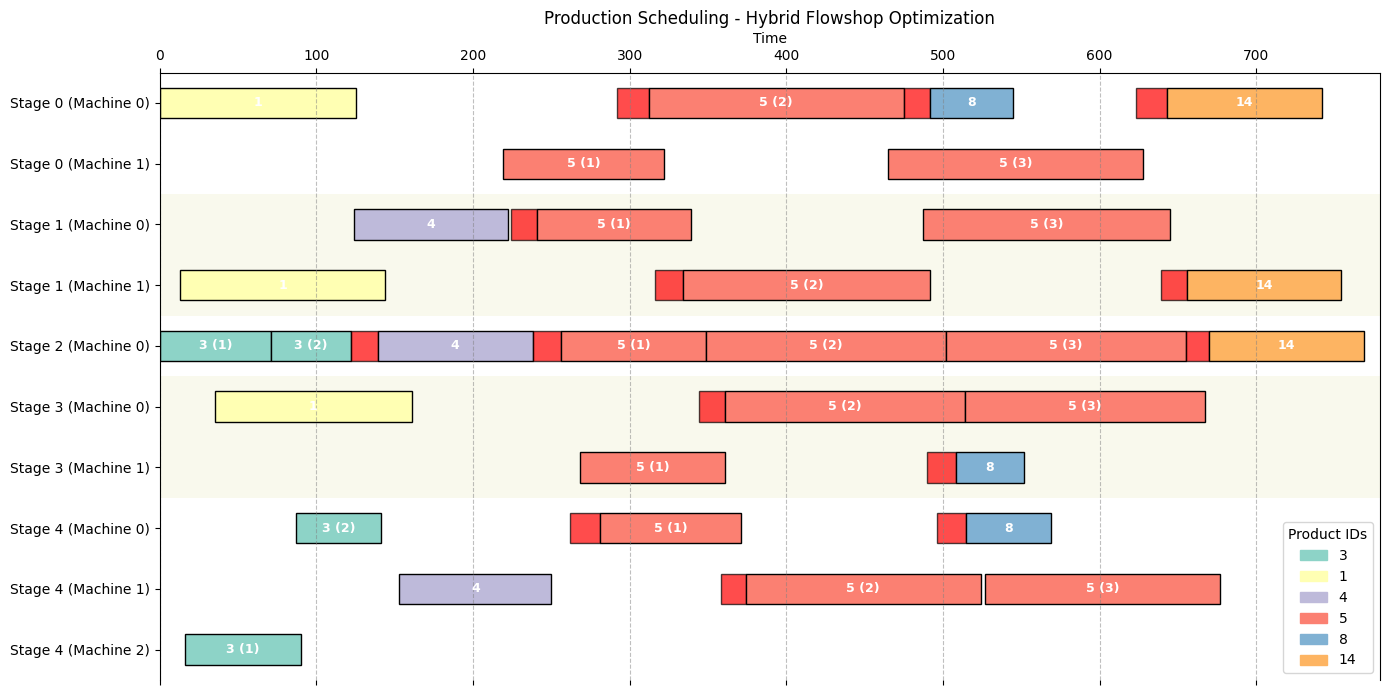

In [157]:
# Extract and display results
best_x = res.X
best_perm = best_x[:problem.seq_length]
makespan = problem.calculate_makespan(best_x, store_best=True)
problem.best_perm = best_perm

print("====" * 20)
print("Original sequence of product IDs:", user_sequence_ids)
print("Best permutation of indices:", best_perm)
print("Best sequence of product IDs:", problem.best_sequence_ids)
print("Best machine choices per product and stage:\n", problem.best_machine_choices)
print("Best makespan:", problem.max_makespan)

problem.plot_gantt_chart()

# # Export the schedule for JS Gantt chart
# schedule_export = problem.export_schedule_for_js()
# print("Exported schedule for JS Gantt chart:")
# for entry in schedule_export:
#     print(entry)

In [158]:
def minimize_machines_postprocess(problem):
    """
    Try to reassign jobs to fewer machines per stage, without increasing waiting times.
    Updates problem.best_machine_choices in place.
    """
    machine_choices = problem.best_machine_choices.copy()
    start_times = problem.best_start_times
    end_times = problem.best_end_times
    seq_length, n_stages = machine_choices.shape
    machines_per_stage = problem.machines_per_stage

    for s in range(n_stages):
        # Only consider jobs that require this stage
        jobs_with_stage = [i for i in range(seq_length) if start_times[i, s] >= 0]
        if not jobs_with_stage:
            continue

        # Sort jobs by start time at this stage
        jobs_sorted = sorted(jobs_with_stage, key=lambda i: start_times[i, s])
        print('Sorted jobs for stage', s, ':', jobs_sorted)
        print('Sorted product ids for stage', s, ':', [problem.best_sequence_ids[j] for j in jobs_sorted])
        new_assignments = np.full(seq_length, -1)
        machine_end_times = [0] * machines_per_stage[s]
        used_machines = []

        for job_idx in jobs_sorted:
            assigned_flag = False
            for m in used_machines:
                last_end = machine_end_times[m]
                if start_times[job_idx, s] >= last_end:
                    new_assignments[job_idx] = m
                    machine_end_times[m] = end_times[job_idx, s]
                    assigned_flag = True
                    break
            if not assigned_flag:
                for m in range(machines_per_stage[s]):
                    if m not in used_machines:
                        new_assignments[job_idx] = m
                        machine_end_times[m] = end_times[job_idx, s]
                        used_machines.append(m)
                        break

        # Update machine choices for this stage (only for jobs that require this stage)
        for job_idx in jobs_with_stage:
            machine_choices[job_idx, s] = new_assignments[job_idx]

    # Update the problem with the new machine assignments
    problem.best_machine_choices = machine_choices

    # Recompute makespan and times for consistency
    # (if you want to update Gantt chart, etc.)
    x = np.concatenate([problem.best_perm, machine_choices.flatten()])
    problem.calculate_makespan(x, store_best=True)

    print("Post-processing complete. New machine assignments minimize machine usage per stage.")

Unique machines used per stage BEFORE post-processing:
Stage 0: 2 machines used: [0 1]
Stage 1: 2 machines used: [0 1]
Stage 2: 1 machines used: [0]
Stage 3: 2 machines used: [0 1]
Stage 4: 3 machines used: [0 1 2]
Sorted jobs for stage 0 : [2, 4, 5, 6, 7, 8]
Sorted product ids for stage 0 : [1, 5, 5, 5, 8, 14]
Sorted jobs for stage 1 : [2, 3, 4, 5, 6, 8]
Sorted product ids for stage 1 : [1, 4, 5, 5, 5, 14]
Sorted jobs for stage 2 : [0, 1, 3, 4, 5, 6, 8]
Sorted product ids for stage 2 : [3, 3, 4, 5, 5, 5, 14]
Sorted jobs for stage 3 : [2, 4, 5, 7, 6]
Sorted product ids for stage 3 : [1, 5, 5, 8, 5]
Sorted jobs for stage 4 : [0, 1, 3, 4, 5, 7, 6]
Sorted product ids for stage 4 : [3, 3, 4, 5, 5, 8, 5]
Calculating makespan for sequence: [1 1 0 2 3 3 3 4 5]
With machine choices:
[[1 1 0 0 0]
 [1 1 0 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]
 [1 1 0 1 1]
 [0 0 0 1 2]]
  [DEBUG] Job 0, Product 3: Wait/transport time after stage 2 = 1
--------------------
Job 0, Pr

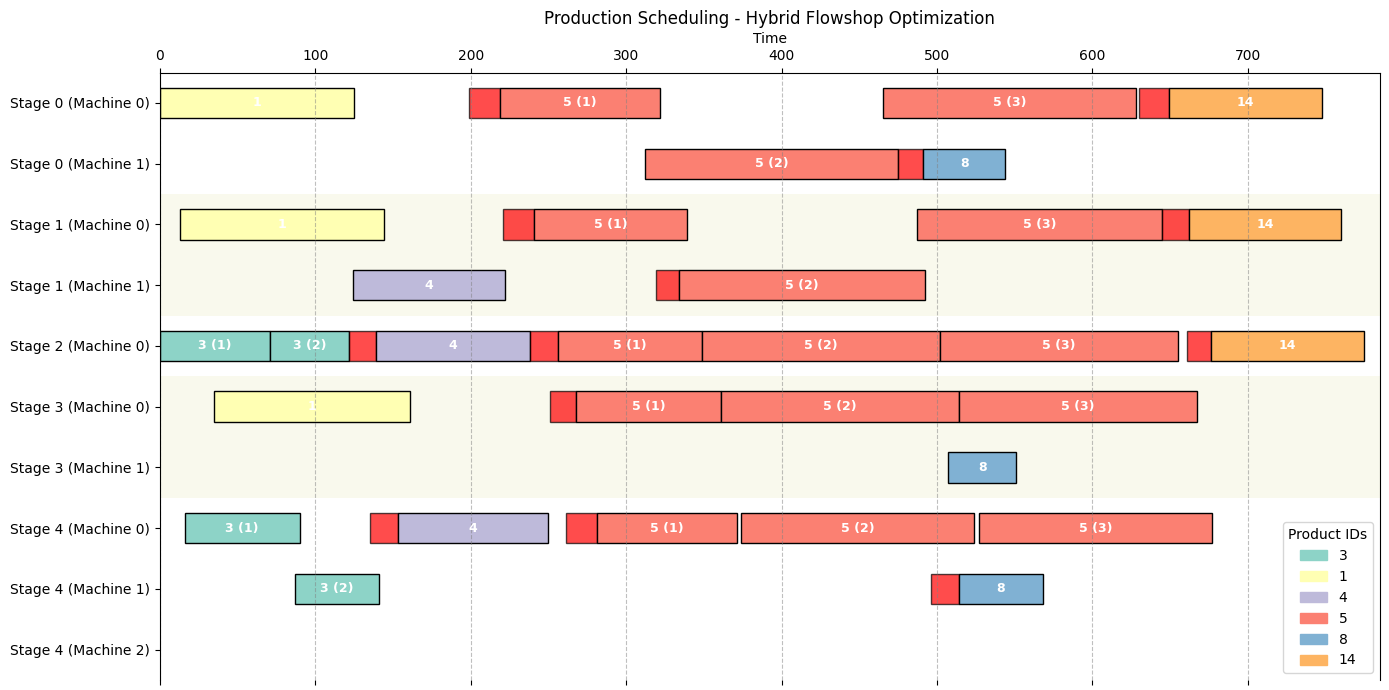

In [159]:
# Post-process to minimize machine usage (Optional)
print("Unique machines used per stage BEFORE post-processing:")
for s in range(problem.n_stages):
    jobs_with_stage = [i for i in range(problem.seq_length) if problem.best_start_times[i, s] >= 0]
    unique_machines = np.unique(problem.best_machine_choices[jobs_with_stage, s]) if jobs_with_stage else []
    print(f"Stage {s}: {len(unique_machines)} machines used: {unique_machines}")

minimize_machines_postprocess(problem)

print("Unique machines used per stage AFTER post-processing:")
for s in range(problem.n_stages):
    jobs_with_stage = [i for i in range(problem.seq_length) if problem.best_start_times[i, s] >= 0]
    unique_machines = np.unique(problem.best_machine_choices[jobs_with_stage, s]) if jobs_with_stage else []
    print(f"Stage {s}: {len(unique_machines)} machines used: {unique_machines}")

print("====" * 20)
print("Original sequence of product IDs:", user_sequence_ids)
print("Best permutation of indices:", best_perm)
print("Best sequence of product IDs:", problem.best_sequence_ids)
print("Best machine choices per product and stage:\n", problem.best_machine_choices)
print("Best makespan:", problem.max_makespan)

problem.plot_gantt_chart()

# # Export the schedule for JS Gantt chart
# schedule_export = problem.export_schedule_for_js()
# print("Exported schedule for JS Gantt chart:")
# for entry in schedule_export:
#     print(entry)